# Multimodal Article Question Answering Assistant

Code authored by: Shaw Talebi

[Blog link](https://medium.com/towards-data-science/multimodal-rag-process-any-file-type-with-ai-e6921342c903) 
| [Video link](https://youtu.be/Y7pNmocrmi8)

### imports

In [1]:
import json
from functions import *
from transformers import CLIPProcessor, CLIPModel
from torch import load, matmul, argsort
from torch.nn.functional import softmax

from IPython.display import Image

import ollama

### load data

In [2]:
# load article contents
text_content_list = load_from_json('data/text_content.json')
image_content_list = load_from_json('data/image_content.json')

# load embeddings
text_embeddings = load('data/text_embeddings.pt', weights_only=True)
image_embeddings = load('data/image_embeddings.pt', weights_only=True)

In [3]:
print(text_embeddings.shape)
print(image_embeddings.shape)

torch.Size([86, 512])
torch.Size([17, 512])


In [4]:
text_content_list[49]

{'article_title': 'Multimodal Models\u200a—\u200aLLMs that can see and hear',
 'section': 'Path 1: LLM +\xa0Tools',
 'text': 'The key benefit of such an approach is simplicity. Tools can quickly be assembled without any additional model training.'}

### query

In [5]:
# query
query = "What is CLIP's contrastive loss function?"
# query = "What are the three paths described for making LLMs multimodal?"
# query = "What is an intuitive explanation of multimodal embeddings?"

# embed query
query_embed = embed_text(query)

In [6]:
query_embed.shape

torch.Size([1, 512])

### Multimodal search

In [7]:
k = 5
threshold = 0.1

# multimodal search over articles
text_similarities = matmul(query_embed, text_embeddings.T)
image_similarities = matmul(query_embed, image_embeddings.T)

# rescale similarities via softmax
temp=0.25
text_scores = softmax(text_similarities/temp, dim=1)
image_scores = softmax(image_similarities/temp, dim=1)

# return top k filtered text results
isorted_scores = argsort(text_scores, descending=True)[0]
sorted_scores = text_scores[0][isorted_scores]

itop_k_filtered = [idx.item() for idx, score in zip(isorted_scores, sorted_scores) if score.item() >= threshold][:k]
top_k = [text_content_list[i] for i in itop_k_filtered]

top_k

[{'article_title': 'Multimodal Embeddings: An Introduction',
  'section': 'Contrastive Learning',
  'text': 'Two key aspects of CL contribute to its effectiveness'}]

#### text and image search

In [8]:
text_results, text_scores = similarity_search(query_embed, text_embeddings, text_content_list, k=15, threshold=0.01, temperature=0.25)
image_results, image_scores = similarity_search(query_embed, image_embeddings, image_content_list, k=5, threshold=0.25, temperature=0.5)

In [9]:
i=1
for text in text_results:
    if text_results:
        print(i, "-", text['text'])
        i=i+1

1 - Two key aspects of CL contribute to its effectiveness
2 - To make a class prediction, we must extract the image logits and evaluate which class corresponds to the maximum.
3 - Next, we can import a version of the clip model and its associated data processor. Note: the processor handles tokenizing input text and image preparation.
4 - The basic idea behind using CLIP for 0-shot image classification is to pass an image into the model along with a set of possible class labels. Then, a classification can be made by evaluating which text input is most similar to the input image.
5 - We can then match the best image to the input text by extracting the text logits and evaluating the image corresponding to the maximum.
6 - The code for these examples is freely available on the GitHub repository.
7 - We see that (again) the model nailed this simple example. But let’s try some trickier examples.
8 - Next, we’ll preprocess the image/text inputs and pass them into the model.
9 - Another practi

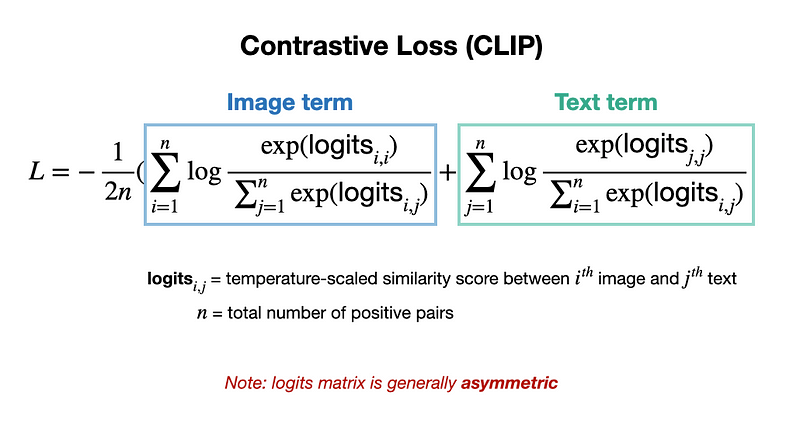

In [10]:
for image in image_results:
    display(Image(filename=image['image_path']))

### Prompt Engineering

#### format context

In [11]:
text_context = ""
for text in text_results:
    if text_results:
        text_context = text_context + "**Article title:** " + text['article_title'] + "\n"
        text_context = text_context + "**Section:**  " + text['section'] + "\n"
        text_context = text_context + "**Snippet:** " + text['text'] + "\n\n"

In [12]:
image_context = ""
for image in image_results:
    if image_results:
        image_context = image_context + "**Article title:** " + image['article_title'] + "\n"
        image_context = image_context + "**Section:**  " + image['section'] + "\n"
        image_context = image_context + "**Image Path:**  " + image['image_path'] + "\n"
        image_context = image_context + "**Image Caption:** " + image['caption'] + "\n\n"

#### prompt construction

In [13]:
# construct prompt template
prompt = f"""Given the query "{query}" and the following relevant snippets:

{text_context}
{image_context}

Please provide a concise and accurate answer to the query, incorporating relevant information from the provided snippets where available.

"""

In [14]:
print(prompt)

Given the query "What is CLIP's contrastive loss function?" and the following relevant snippets:

**Article title:** Multimodal Embeddings: An Introduction
**Section:**  Contrastive Learning
**Snippet:** Two key aspects of CL contribute to its effectiveness

**Article title:** Multimodal Embeddings: An Introduction
**Section:**  Example Code: Using CLIP for 0-shot classification and image search
**Snippet:** To make a class prediction, we must extract the image logits and evaluate which class corresponds to the maximum.

**Article title:** Multimodal Embeddings: An Introduction
**Section:**  Example Code: Using CLIP for 0-shot classification and image search
**Snippet:** Next, we can import a version of the clip model and its associated data processor. Note: the processor handles tokenizing input text and image preparation.

**Article title:** Multimodal Embeddings: An Introduction
**Section:**  Example Code: Using CLIP for 0-shot classification and image search
**Snippet:** The basic 

### Prompt LLM

In [15]:
ollama.pull('llama3.2-vision')

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [16]:
response = ollama.chat(
    model='llama3.2-vision',
    messages=[{
        'role': 'user',
        'content': prompt,
        'images': [image["image_path"] for image in image_results]
    }]
)

print(response['message']['content'])

The image depicts a contrastive loss function for aligning text and image representations in multimodal models. The function is designed to minimize the difference between the similarity of positive pairs (text-image) and negative pairs (text-text or image-image). This loss function is commonly used in CLIP, which stands for Contrastive Language-Image Pre-training.

**Key Components:**

*   **Positive Pairs:** Text-image pairs where the text describes an image.
*   **Negative Pairs:** Text-text or image-image pairs that do not belong to the same class.
*   **Contrastive Loss Function:** Calculates the difference between positive and negative pairs' similarities.

**How it Works:**

1.  **Text-Image Embeddings:** Generate embeddings for both text and images using a multimodal encoder (e.g., CLIP).
2.  **Positive Pair Similarity:** Calculate the similarity score between each text-image pair.
3.  **Negative Pair Similarity:** Calculate the similarity scores between all negative pairs.
4. 